# Approccio orientato ai dati

## Metodo di apprendimento automatico

L'approccio connettivista prevede l'utilizzo di un modello di rete neurale, come un semplice perceptron, per imparare i modelli dei nomi. Le fasi comprendono:

1. **Codifica dei dati**: Convertire i nomi in un formato adatto all'addestramento della rete neurale (ad esempio, codifica a un punto).
2. **Addestramento del modello**: Addestrare un semplice perceptron sul set di dati. L'input potrebbe essere costituito da sequenze di caratteri e l'obiettivo potrebbe essere il carattere successivo del nome.
3. **Valutazione della perdita**: Utilizzare una funzione di perdita adeguata (come l'entropia incrociata categoriale) per valutare le prestazioni del modello e regolare i pesi di conseguenza.
4. **Generazione del nome**: Utilizzare il modello addestrato per prevedere i caratteri successivi, a partire da un carattere o una sequenza iniziale, per generare nuovi nomi.

In [1]:
# Load the dataset
file_path = '../data/names.txt'

# Read the file and process it for bigram frequency analysis
with open(file_path, 'r', encoding='utf-8') as file:
    names = file.read().splitlines()

print(names[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


### Fase 1: Preparazione dei dati

È necessario convertire i nomi in un formato che una rete neurale possa elaborare. Di solito questo comporta la codifica di ogni carattere in un formato numerico, come la codifica *one-hot*.

Una volta trovato il nostro alfabeto, procediamo in due fasi:

1. **Codifica dei caratteri**: Convertire ogni carattere in un indice numerico.
2. **One-hot encoding**: Convertire ogni indice in un vettore di zeri, tranne che per un 1 nella posizione dell'indice.

Per prima cosa troviamo il nostro alfabeto:

In [2]:
set(''.join(names))

{'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [3]:
# Create a set of all unique characters in the names
unique_chars = set(''.join(names))
unique_chars = sorted(unique_chars)

# Pretty print the unique characters and the length of the set
print(f"{len(unique_chars)} caratteri univoci:", unique_chars)

26 caratteri univoci: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Creiamo un dizionario che **mappa ogni carattere in un indice numerico**.

#### Esempio:

I primi dieci elementi del dizionario sono i seguenti:
    
```python
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, ..., '.': 0}
```

In [4]:
# Create a dictionary to map each character to a unique integer. Add '.' as a special character
# char_to_int = {c: i+1 for i, c in zip(range(len(unique_chars)), unique_chars) }
char_to_int = {c: i+1 for i, c in enumerate(unique_chars)}
char_to_int['.'] = 0

#  Create a dictionary to convert back
int_to_char = {i: c for c, i in char_to_int.items()}

# Pretty print the dictionaries
print(char_to_int)
print(int_to_char)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
names[0]

'emma'

Convertiamo ogni nome nella sua **rappresentazione numerica** con l'ausilio dei dizionari ``char_to_int`` e ``int_to_char``.

#### Esempio:

```python
'.emma.' --> [0, 5, 13, 13, 1, 0] --> '.emma.'
```


In [6]:
# For each name add a special char '.' at the beginning and the end
# new_names = []
# for name in names:
#     new_name = '.' + name + '.'
#     new_names.append(new_name)
# names = new_names

names = ['.' + name + '.' for name in names]

# Convert names to integer representation
int_names = [[char_to_int[char] for char in name] for name in names]

# Convert the first name to integer representation
print(names[0], '-->', int_names[0], '-->',
      ''.join([int_to_char[value] for value in int_names[0]]))

.emma. --> [0, 5, 13, 13, 1, 0] --> .emma.


Codifichiamo ogni nome in formato [one-hot-encoding](https://en.wikipedia.org/wiki/One-hot).
Potremmo usare quella di [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), il risultato sarebbe lo stesso.

Inoltre, stabiliamo qui e ora il numero massimo di caratteri che vogliamo considerare per ogni nome. Questo è necessario per creare un tensore di input di dimensioni fisse.

In [7]:
max([len(name) for name in int_names])

17

In [8]:
# ! pip install numpy
import numpy as np

# La dimensione della rappresentazione corrisponde alla lunghezza massima
max_name_length = max([len(name) for name in int_names])
max_name_length = 17

# Codifica one-hot
n_chars = len(unique_chars)
one_hot_encoded = np.zeros(
    (len(int_names), max_name_length, n_chars+1), dtype=np.float32)
for i, name in enumerate(int_names):
    for j, char_int in enumerate(name):
        one_hot_encoded[i, j, char_int] = 1.0

print(one_hot_encoded.shape)

(32033, 17, 27)


In [9]:
one_hot_encoded[0]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


#### Visualizzazione dei dati

Confrontiamo la rappresentazione di due nomi **in formato one-hot-encoding**.

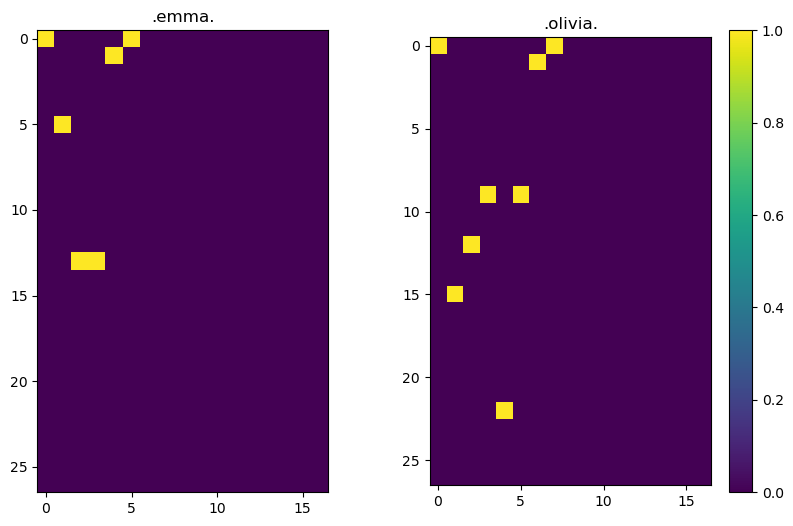

In [10]:
! pip install matplotlib
import matplotlib.pyplot as plt

# plot the first two names in the dataset
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title(names[0])
plt.imshow(one_hot_encoded[0].T)
plt.subplot(1, 2, 2)
plt.title(names[1])
plt.imshow(one_hot_encoded[1].T)
plt.colorbar()
plt.show()

In [11]:
# Define the bigram frequency matrix
bigram_freq_matrix = np.zeros((n_chars+1, n_chars+1), dtype=np.float32)

# For each name in the dataset
for name in int_names:
    # For each bigram in the name
    for i in range(len(name)-1):
        # Get the first and second char integer representation
        char1 = name[i]
        char2 = name[i+1]
        # Increment the frequency count
        bigram_freq_matrix[char1, char2] += 1

In [12]:
bigram_freq_matrix.shape

(27, 27)

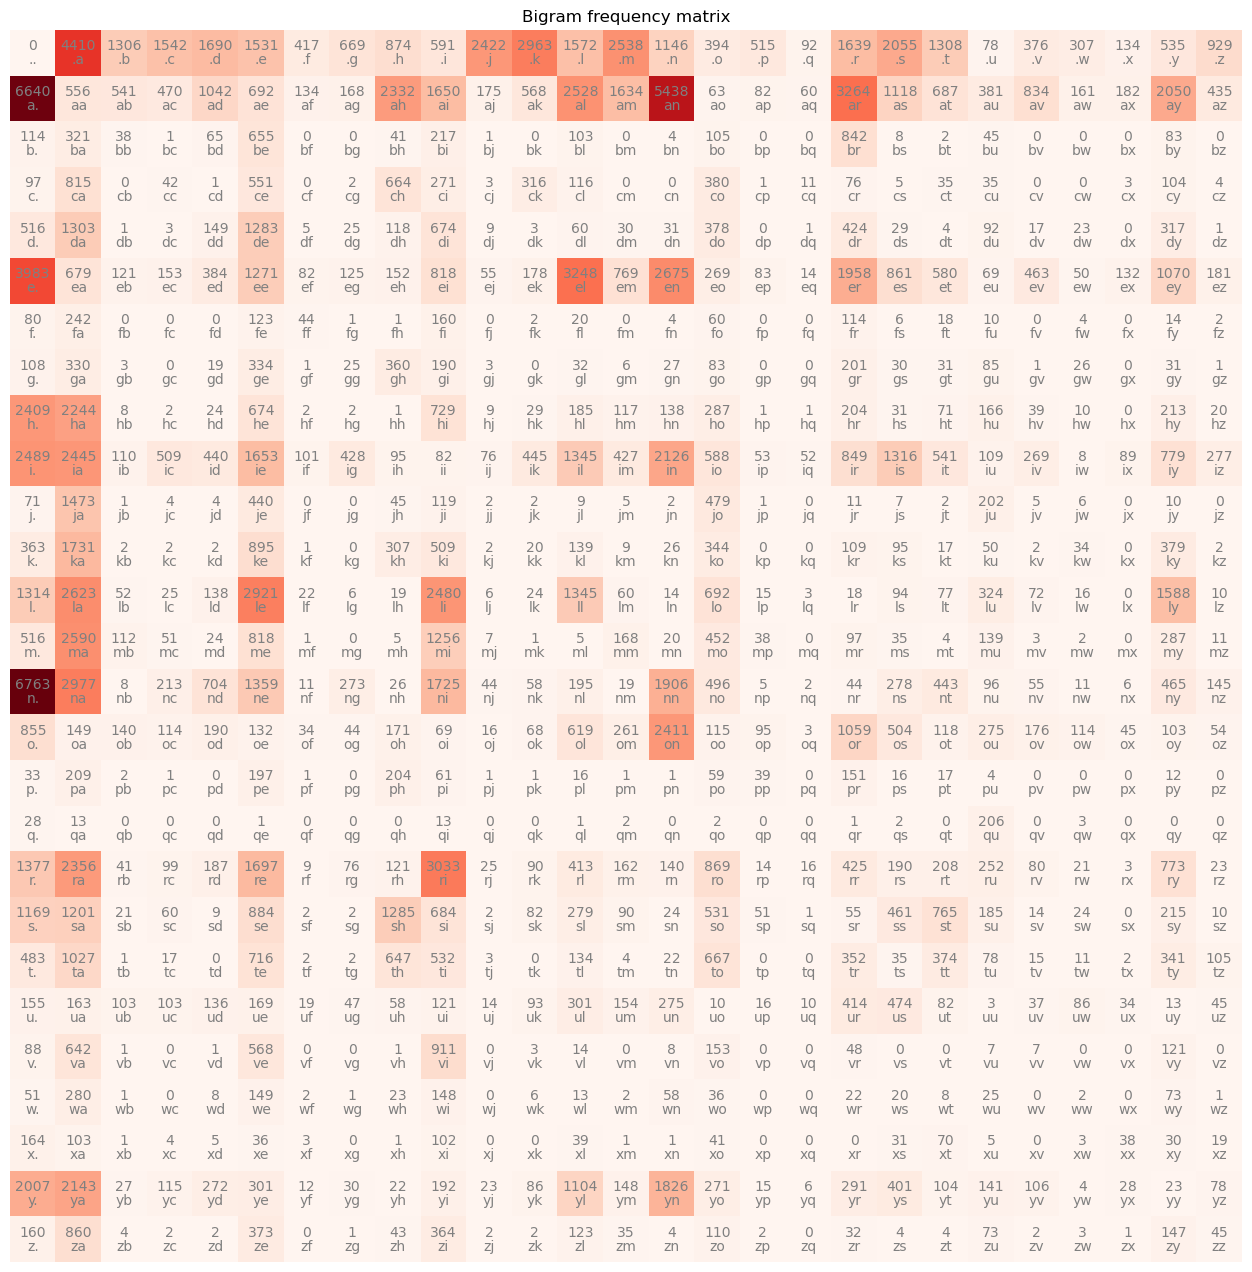

In [13]:
import matplotlib.pyplot as plt

# Plot the matrix mapping the frequency of each bigram
plt.figure(figsize=(16, 16))
plt.title('Bigram frequency matrix')
plt.imshow(bigram_freq_matrix, cmap='Reds')
for i in range(27):
    for j in range(27):
        plt.text(
            j, i, f"{int_to_char[i]}{int_to_char[j]}", ha='center', va='top', color='gray')
        plt.text(
            j, i, f"{bigram_freq_matrix[i, j]:.0f}", ha='center', va='bottom', color='gray')
plt.xticks(range(27), list(unique_chars) + ['.'])
plt.yticks(range(27), list(unique_chars) + ['.'])
plt.axis('off')
plt.show()

Esploriamo **i bigrammi** e come rappresentano i nomi, in termini di probabilità, e attraverso il loro valore di *log-likelihood*.

#### Esempio:

Quale è la *likelihood* che un nome inizi con la lettera 'e'?

In [14]:
bigram_prob_matrix = np.zeros((n_chars+1, n_chars+1), dtype=np.float32)

# Compute the probability matrix
for i in range(n_chars+1):
    total_count = bigram_freq_matrix[i].sum()
    if total_count != 0:
        bigram_prob_matrix[i] = bigram_freq_matrix[i] / total_count

In [15]:
bigram_prob_matrix.shape

(27, 27)

In [16]:
27*27

729

In [17]:
# Leggiamo la prima riga della matrice di frequenza dei bigrammi che iniziamo con il carattere '.'.
print("Frequenze del primo carattere uguale ad 'e' in un nome",
      bigram_freq_matrix[char_to_int['n']][char_to_int['.']])

# Probabilità che il primo carattere sia esattamente 'e'
print("Probabilità che il primo carattere sia esattamente 'e'",
      bigram_prob_matrix[char_to_int['n']][char_to_int['.']])

Frequenze del primo carattere uguale ad 'e' in un nome 6763.0
Probabilità che il primo carattere sia esattamente 'e' 0.36901838


#### Esempio:

**Ancora un approccio frequentista**: generare un nuovo nome significa pescare un carattere alla volta, in base alla probabilità che sia il successivo.

In [18]:
# Peschiamo dalla distribuzione multinomiale
import torch
g = torch.Generator().manual_seed(43)

for i in range(7):
    multinomial_pick = torch.multinomial(
        torch.tensor(bigram_prob_matrix[i]), num_samples=1, generator=g).item()
    char_pick = int_to_char[multinomial_pick]
    print(
        f"Peschiamo il carattere n.{i+1} dalla distribuzione di probabilità: '{char_pick}'")
    if char_pick == '.':
        break

Peschiamo il carattere n.1 dalla distribuzione di probabilità: 'r'
Peschiamo il carattere n.2 dalla distribuzione di probabilità: 'e'
Peschiamo il carattere n.3 dalla distribuzione di probabilità: 'r'
Peschiamo il carattere n.4 dalla distribuzione di probabilità: 'a'
Peschiamo il carattere n.5 dalla distribuzione di probabilità: 'r'
Peschiamo il carattere n.6 dalla distribuzione di probabilità: '.'


Produciamo un nome con **un numero arbitrario di caratteri**.

#### Esempio:

```python
Nome generato n.1: 'anugeenvi.'
Nome generato n.2: 's.'
Nome generato n.3: 'mabian.'
Nome generato n.4: 'dan.'
Nome generato n.5: 'stan.'
```

In [23]:
g = torch.Generator().manual_seed(44)  # riproducibilità
multinomial_pick = torch.multinomial(
    torch.tensor([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]),
    num_samples=1,
    generator=g).item()  # pseudo-random pick
print(multinomial_pick)

2


In [20]:
# Peschiamo dalla distribuzione multinomiale
import torch
g = torch.Generator().manual_seed(42)  # riproducibilità


def generate_name():
    int_pick = 0
    gen_name = []
    while True:
        p = torch.tensor(bigram_prob_matrix[int_pick])
        int_pick = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        char_pick = int_to_char[int_pick]
        gen_name.append(char_pick)
        if char_pick == '.':
            break
    return ''.join(gen_name)


for i in range(5):
    print(f"Nome generato n.{i+1}: '{generate_name()}'")

Nome generato n.1: 'anugeenvi.'
Nome generato n.2: 's.'
Nome generato n.3: 'mabian.'
Nome generato n.4: 'dan.'
Nome generato n.5: 'stan.'


### Passo 2: Progettazione del percettrone

È possibile progettare un semplice perceptron usando le librerie `numpy` e `pytorch`.

In [81]:
input_size = len(char_to_int)  # Number of unique characters
output_size = len(char_to_int)  # Same as the number of unique characters

print(f"Input size: {input_size}, Output size: {output_size}")

Input size: 27, Output size: 27


In [83]:
import random
p = 0.9
w = random.random()
p *= w
w += qualcosa
p *= w

0.5754841186120954